In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import GAN
import utils.ganconfig as ganconfig
import torchvision.utils as vutils
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import torch.nn.functional as F
import torchaudio
import librosa
import math

## Some tests of GAN 

In [2]:
# Root directory for dataset
dataroot = "pretty_face"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

#Size of z latent vector (i.e. size of generator input)
nz = 100
#
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

ngpu = 1


### DCGAN generator

In [3]:
# DCGAN generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### Load the model

In [4]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
model = Generator(ngpu)
model.load_state_dict(torch.load("GAN/prettyFace_Generater_size64.pth", map_location=device))
model.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Face generation

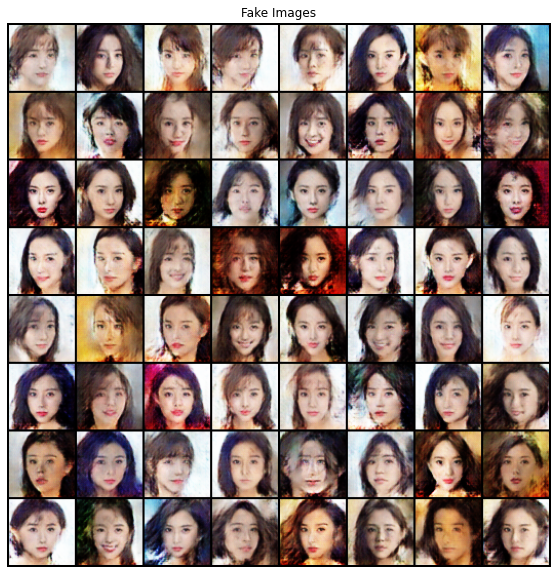

In [5]:
torch.manual_seed(0)
fixed_noise = torch.randn(64, ganconfig.nz, 1, 1, device=device)
img_list = []
with torch.no_grad():
    fake = model(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

### add the difference vector to latent features

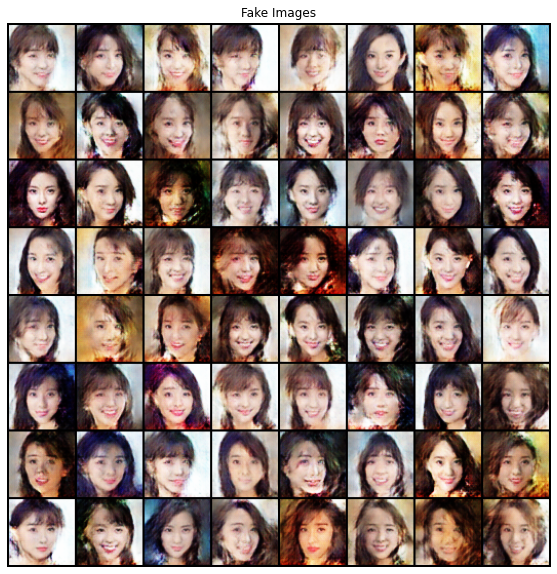

In [6]:
latent_features = fixed_noise
smile_set = latent_features[[12, 26, 35, 37, 57],:]
normal_set = latent_features[[4, 5, 21, 63, 39],:]
# difference vector
diff_vec = torch.mean((smile_set-normal_set),0,True)
# add the difference vector to the latent features
smile_fixed_noise = fixed_noise + diff_vec
# Plot images
img_list = []
with torch.no_grad():
    fake = model(smile_fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

## What features affect the performance?

<AxesSubplot:>

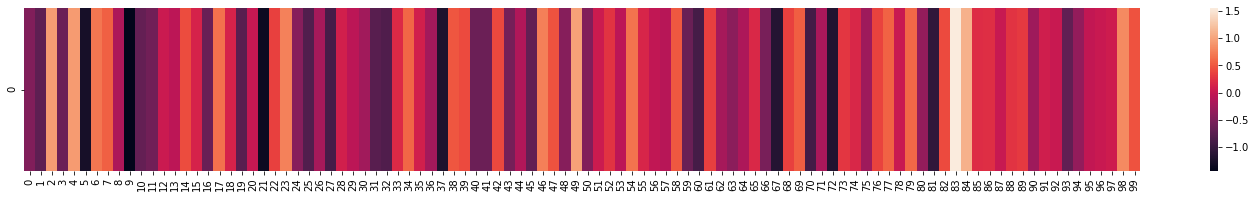

In [7]:
plt.figure(figsize=(25,3))
sns.heatmap(diff_vec.cpu().squeeze(2).squeeze(2).numpy())

##### By the observation, I found that significant differences are at indices [5, 9, 21, 37, 67, 70, 72 81, 83]. But I found that the postive differnece also affect the performance. So I tried to find out both postive and negative difference.

In [8]:
## In this case, I tried to use Kmeans to group the data into 3 cluster(great)
diff_vec_np = diff_vec.cpu().squeeze(2).squeeze(2).numpy().reshape(-1,1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(diff_vec_np)

KMeans(n_clusters=3)

centroid points: p1, p2, p3

        |---------------------------------------------------------------------------|
                   ^                      ^                          ^
                   |                      |                          |
        <==========p1                     p2                         p3=============>


In [9]:
kmeans.cluster_centers_

array([[ 0.00695224],
       [-0.7772555 ],
       [ 0.63837296]], dtype=float32)

In [10]:
print("the number of parameters that greater than the threshold:", np.sum(diff_vec_np>0.63837296))
print("the number of parameters that smaller than the threshold:", np.sum(diff_vec_np<-0.7772555))

the number of parameters that greater than the threshold: 11
the number of parameters that smaller than the threshold: 12


In [11]:
postive_idx = (diff_vec_np>0.63837296).nonzero()[0]
negative_idx = (diff_vec_np<-0.7772555).nonzero()[0]

In [12]:
postive_idx, negative_idx

(array([ 2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98]),
 array([ 5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81]))

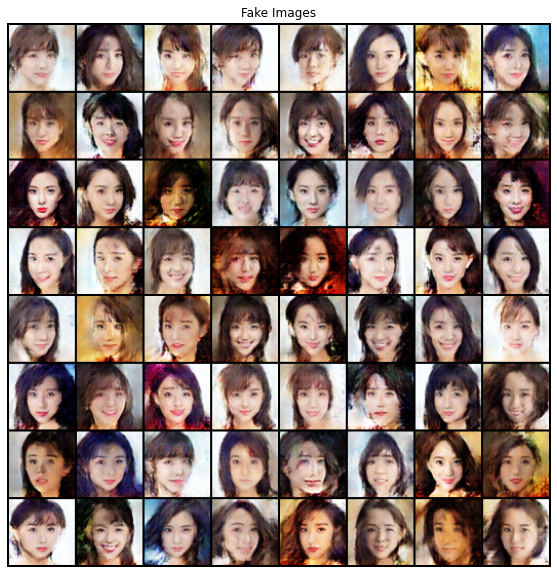

In [13]:
img_list=[]
manual_smile_fixed_noise = fixed_noise
manual_smile_fixed_noise[:,[2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98],...] += 0.63837296
manual_smile_fixed_noise[:,[5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81],...] -= 0.7772555
with torch.no_grad():
    fake = model(manual_smile_fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

### Background color

In [14]:
yellow_bgc = [6, 8, 33]
white_bgc = [3, 29, 42]

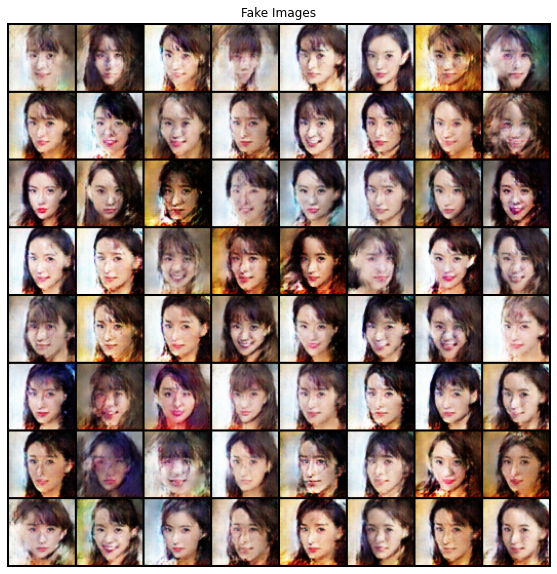

In [15]:
latent_features = fixed_noise
yellow_set = latent_features[yellow_bgc,:]
white_set = latent_features[white_bgc,:]
bgc_img_list = []
# difference vector
bgc_diff_vec = torch.mean((yellow_set-white_set),0,True)
# add the difference vector to the latent features
bgc_fixed_noise = fixed_noise + bgc_diff_vec
# Plot images
img_list = []
with torch.no_grad():
    fake = model(bgc_fixed_noise).detach().cpu()
    bgc_img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(bgc_img_list[-1], (1, 2, 0)))
plt.show()

## Discussion

<font size=4 >We can figure out what parameters affect the result of the picture so that we can let the generator generate a particular picture. For example, if we know how to generate a smile, we can emphasize relative parameters to make a smiling face when we are generating a happy song or rock song.</font>


## Video generation

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)

Using cache found in /home/physe/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [17]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
print(noise.shape)

torch.Size([4, 512])


In [5]:
with torch.no_grad():
    generated_images = model.test(noise)
print(generated_images.shape)
# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
# grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), nrow=2, scale_each=True, normalize=True)
# plt.figure(figsize=(20,20))
# plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# plt.show()

torch.Size([4, 3, 512, 512])


In [4]:
from features.FeaturesLoader import FeaturesLoader
import mymodels.Models as Models
from PIL import Image

In [5]:
audio_model = Models.CRNNModel()
features_loader = FeaturesLoader(torch_model=audio_model, para_file_path="resources/pth/crnnModel1.pth",frame_len=0.025)

loading the model.......


In [6]:
audio_path = "resources/music/bj_new.mp3"
music_features = features_loader.getFeatures(audio_path)

In [14]:
music_features.shape

torch.Size([15346, 9])

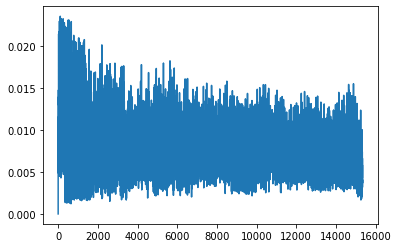

In [15]:
spec_cent = music_features[:,0].numpy()
plt.plot(spec_cent)

In [ ]:
torch.manual_seed(1)

latent_features = torch.randn(15, 512,1,1)

In [19]:
def smile(features, weight):
    features[:,[2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98],...] += 0.63837296*weight
    features[:,[5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81],...] -= 0.7772555*weight
    return features

In [25]:
seconds = 383
seconds_per_key_pic = 5
num_key_pic = math.ceil(seconds/seconds_per_key_pic)
frames_per_second = 40
num_all_pic = math.ceil(num_key_pic*seconds_per_key_pic*frames_per_second)

latent_features = torch.randn(num_key_pic, 512, 1, 1)
latent_features_all = torch.zeros(num_all_pic, 512, 1, 1)

print(num_key_pic, num_all_pic, latent_features.shape, latent_features_all.shape)

for idx in range(num_key_pic):
    latent_features[idx,...] = smile(latent_features[idx,...].unsqueeze(0), music_features[idx*seconds_per_key_pic*frames_per_second, 1])
    latent_features_all[idx*seconds_per_key_pic*frames_per_second,...] = latent_features[idx,...]

    
for idx in range(num_key_pic-1):
    prior_keyimg = latent_features_all[idx*seconds_per_key_pic*frames_per_second, ...]
    nex_keyimg = latent_features_all[(idx+1)*seconds_per_key_pic*frames_per_second, ...]
    difference_matrix = nex_keyimg-prior_keyimg
    partial_spec_cent = music_features[idx*seconds_per_key_pic*frames_per_second:(idx+1)
                                       *seconds_per_key_pic*frames_per_second,0]
    spec_cent_density = partial_spec_cent/torch.sum(partial_spec_cent)
    for i in range(seconds_per_key_pic*frames_per_second):
        latent_features_all[idx*seconds_per_key_pic*frames_per_second+i+1,...] = difference_matrix*spec_cent_density[i] + latent_features_all[idx*seconds_per_key_pic*frames_per_second+i,...]

parent_path = 'bj'
# os.makedirs(parent_path)

for idx in range(num_all_pic):
    with torch.no_grad():
        pic_array = model.test(latent_features_all[idx,...].squeeze().unsqueeze(0).cuda()).squeeze().detach().cpu().permute(1,2,0).numpy()
#     pic_array = model(latent_features_all[idx,...].unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1,2,0).numpy()
    pic_array = (pic_array-np.min(pic_array))/(np.max(pic_array)-np.min(pic_array))
    plt.imsave('resources/imgs/'+parent_path+'/img%d.jpg' % idx, pic_array)
    
    

77 15400 torch.Size([77, 512, 1, 1]) torch.Size([15400, 512, 1, 1])


In [23]:
pic_array = model(prior_keyimg.to(device)).squeeze().detach().cpu().permute(1,2,0).numpy()
pic_array = (pic_array-np.min(pic_array))/(np.max(pic_array)-np.min(pic_array))

NameError: name 'prior_keyimg' is not defined

In [24]:
spec_cent_density

NameError: name 'spec_cent_density' is not defined

In [93]:
prior_keyimg.shape

torch.Size([9])

In [53]:
np.min(pic_array)

-0.31353953

In [96]:
latent_features_all.shape

torch.Size([1500, 100, 1, 1])

In [25]:
y,sr = librosa.load("resources/music/bj_new.mp3")

/home/physe/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [13]:
librosa_spec_cent = librosa.feature.spectral_centroid(y)

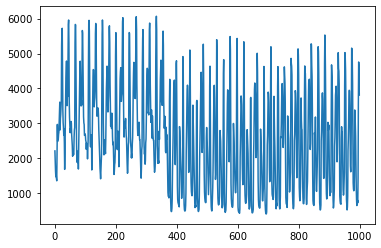

In [16]:
plt.plot(librosa_spec_cent.reshape(-1,)[:1000])

### with beats detection

In [29]:
frame_len_sec = 0.025
signal_librosa,sr_librosa = librosa.load(audio_path,sr=44100)
tempo, beats_librosa = librosa.beat.beat_track(signal_librosa,sr=sr_librosa,hop_length=math.ceil(sr_librosa*frame_len_sec))
beats2time = librosa.frames_to_time(beats_librosa,hop_length=math.ceil(sr_librosa*frame_len_sec),sr=sr_librosa)

/home/physe/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [30]:
spec_cent_librosa = librosa.feature.spectral_centroid(signal_librosa, sr_librosa, n_fft=1200, hop_length=600,win_length=1200).reshape(-1)
spec_cent_beats_librosa = spec_cent_librosa[beats_librosa]
spec_cent_beats_differ_librosa = spec_cent_beats_librosa[:-1]-spec_cent_beats_librosa[1:]
spec_cent_beats_differ_librosa = np.concatenate((spec_cent_beats_differ_librosa,[0,0]))

In [31]:
kmeans_spec_cent_differ_librosa = KMeans(n_clusters=12).fit(spec_cent_beats_differ_librosa.reshape(-1,1))
sorted(kmeans_spec_cent_differ_librosa.cluster_centers_)

[array([-5552.066323]),
 array([-3613.49326229]),
 array([-2451.80137292]),
 array([-1610.07156897]),
 array([-936.43932363]),
 array([-372.61697913]),
 array([107.60892275]),
 array([662.89119933]),
 array([1310.25914974]),
 array([2165.12154094]),
 array([3074.91395252]),
 array([4319.88024902])]

In [32]:
strengthen_beat = beats_librosa[np.where(spec_cent_beats_differ_librosa<31)[0][:-3]]

In [33]:
strengthen_beat = beats_librosa

In [171]:
len(spec_cent_beats_differ_librosa)

737

In [172]:
len(np.where(spec_cent_beats_differ_librosa<31)[0])

376

In [173]:
len(librosa.frames_to_time(strengthen_beat,hop_length=600,sr=44100))

734

In [34]:
seconds = 383
seconds_per_key_pic = 5
num_key_pic = math.ceil(seconds/seconds_per_key_pic)
frames_per_second = 40
num_all_pic = math.ceil(num_key_pic*seconds_per_key_pic*frames_per_second)

latent_features = torch.randn(num_key_pic, 512, 1, 1)
latent_features_all = torch.zeros(num_all_pic, 512, 1, 1)
spec_cent = torch.tensor(spec_cent)

print(num_key_pic, num_all_pic, latent_features.shape, latent_features_all.shape)

# initialize the key frame of latent_features_all
for i in range(num_key_pic):
    latent_features_all[i*seconds_per_key_pic*frames_per_second] = latent_features[i]

    
# emphasize window
emp_win_len = 8
emp_win_len_half = emp_win_len//2
emp_win = torch.hamming_window(emp_win_len).view(-1,1)
emp_rate = 0.15
# insert other frames into latent_features_all to make pictures change with the spectral centroid
for i in range(num_key_pic-1):
    len_block =  seconds_per_key_pic*frames_per_second
    # the difference between to two adjacent key pictures.
    diff_vec = latent_features[i+1] - latent_features[i]
    # convert spectral centroids to the probabilistic density.
    prob_density_spectral_centroids = F.softmax(spec_cent[i*len_block+1:(i+1)*len_block].reshape(-1,1),dim=0)
    # compute the cumulative sum of difference vectors.
    prob_density_spectral_centroids = torch.cumsum(prob_density_spectral_centroids,dim=0)
    beats_idx = strengthen_beat[(i*len_block<strengthen_beat) & (strengthen_beat<(i+1)*len_block)] % len_block
    for idx in beats_idx:
        if 3<idx<len_block-emp_win_len_half:
            prob_density_spectral_centroids[idx-emp_win_len_half:idx+emp_win_len_half] = torch.clip(prob_density_spectral_centroids[idx-emp_win_len_half:idx+emp_win_len_half] * (emp_win * emp_rate+1), max=0.99)
        elif idx>=len_block-emp_win_len_half:
            seq_len = prob_density_spectral_centroids[idx-emp_win_len_half:].shape[0]
            prob_density_spectral_centroids[idx-emp_win_len_half:] = torch.clip(prob_density_spectral_centroids[idx-emp_win_len_half:] * (emp_win[-seq_len:] * emp_rate+1), max=0.99)
        else:
            seq_len = prob_density_spectral_centroids[0:idx+emp_win_len_half].shape[0]
            prob_density_spectral_centroids[0:idx+emp_win_len_half] = torch.clip(prob_density_spectral_centroids[0:idx+emp_win_len_half] * (emp_win[emp_win_len-seq_len:emp_win_len] * emp_rate+1), max=0.99)
    diff_vec_prob = torch.mul(prob_density_spectral_centroids, diff_vec.view(1,-1))
    #emphasize the drum beat
    latent_features_all[i*len_block+1:(i+1)*len_block] = diff_vec_prob.unsqueeze(2).unsqueeze(3)+latent_features[i]
    
parent_path = 'bj'
# os.makedirs(parent_path)

for idx in range(num_all_pic):
    with torch.no_grad():
        pic_array = model.test(latent_features_all[idx,...].squeeze().unsqueeze(0).cuda()).squeeze().detach().cpu().permute(1,2,0).numpy()
#     pic_array = model(latent_features_all[idx,...].unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1,2,0).numpy()
    pic_array = (pic_array-np.min(pic_array))/(np.max(pic_array)-np.min(pic_array))
    plt.imsave('resources/imgs/'+parent_path+'/img%d.jpg' % idx, pic_array)
    


<ipython-input-34-4496be0a997f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spec_cent = torch.tensor(spec_cent)


77 15400 torch.Size([77, 512, 1, 1]) torch.Size([15400, 512, 1, 1])


In [120]:
latent_features_all.shape

torch.Size([15400, 100, 1, 1])

In [117]:
len_block, beats_idx

(200, array([ 16,  37,  98, 139, 180]))

In [71]:
a = np.array([1,2,3,4,5,6,7,8,9,0])
i=3
a[i-2:3] if i-2>0 else a[0:3]

array([2, 3])

In [80]:
torch.hann_window

tensor([0.0000, 0.2500, 0.7500, 1.0000, 0.7500, 0.2500])

RuntimeError: The size of tensor a (0) must match the size of tensor b (5) at non-singleton dimension 0

In [65]:
(torch.sum(spec_cent_density[:i])+window)

tensor([1.0750, 1.3928, 1.9800, 1.9800, 1.3928])

In [175]:
signal, sr = librosa.load("resources/music/bj_new.mp3", sr=44100)

/home/physe/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


AttributeError: 'numpy.ndarray' object has no attribute '_perc'

In [176]:
signal_harm, signal_perc = librosa.effects.hpss(signal)

In [179]:
import soundfile

In [180]:
soundfile.write('harm_bj.wav', signal_harm, sr)

In [181]:
soundfile.write('prec_bj.wav', signal_perc, sr)

In [22]:
import librosa

In [23]:
import torch.optim as optim

from models.__pycache__.models.base_GAN import BaseGAN
from models.__pycache__.models.utils.config import BaseConfig
from models.__pycache__.models.networks.DCGAN_nets import GNet, DNet
from models.__pycache__.models.DCGAN import DCGAN



In [24]:
model = DCGAN()
use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)

Using cache found in /home/physe/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


ModuleNotFoundError: No module named 'models.DCGAN'